In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from math import pi
import sys

# sys.stderr = open(snakemake.log[0], "w")
from sklearn import linear_model
from typing import List, Tuple
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
plt.style.use("ggplot")
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]

DELIM = ","
PAIR_IDX = ("sample1", "sample2")
BLACK = "#4c566a"
BLUE = ggplot_cm[1]
PURPLE = ggplot_cm[2]
YELLOW = ggplot_cm[4]
RED = ggplot_cm[0]
XCOL = "COMPASS_dist"
YCOL = "ont_dist"


def robust_regression(x: List[float], y: List[float]) -> List[float]:
    """Returns the prediction of the model. This prediction is used with X to plot
    line of best fit and get equation for that line.
    """
    X = [[v] for v in x]
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X, y)
    pred = ransac.predict(X)
    return pred


def fit_model(
        x: List[float], y_pred: List[float]
) -> Tuple[float, float, float, float, float]:
    """Returns: gradient, intercept, r_value, p_value, std_err"""
    return stats.linregress(x, y_pred)


class AsymmetrixMatrixError(Exception):
    pass


def load_matrix(fpath, delim: str = DELIM, name: str = "") -> pd.DataFrame:
    matrix = []
    with open(fpath) as instream:
        header = next(instream).rstrip()
        names = np.array(header.split(delim)[1:])
        idx = np.argsort(names)
        sorted_names = names[idx]
        for row in map(str.rstrip, instream):
            # sort row according to the name sorting
            sorted_row = np.array(row.split(delim)[1:], dtype=int)[idx]
            matrix.append(sorted_row)

    sorted_matrix = np.array(matrix)[idx]
    n_samples = len(sorted_names)
    diagonal_is_zero = all(sorted_matrix[i, i] == 0 for i in range(n_samples))
    if not diagonal_is_zero:
        raise AsymmetrixMatrixError("Distance matrix diagonal is not all zero")

    matrix_is_symmetric = np.allclose(sorted_matrix, sorted_matrix.T)
    if not matrix_is_symmetric:
        raise AsymmetrixMatrixError("Distance matrix is not symmetric")

    mx = pd.DataFrame(sorted_matrix, columns=sorted_names, index=sorted_names)
    # remove the lower triangle of the matrix and the middle diagonal
    mx = mx.where(np.triu(np.ones(mx.shape), k=1).astype(bool))
    mx = mx.stack().rename(name).astype(int)
    mx = mx.rename_axis(PAIR_IDX)

    return mx


# load the data
compass_df = load_matrix("compass.matrix.csv", name=XCOL)
ont_df = load_matrix("bcftools.matrix.csv", name=YCOL)
# merge the matrices
data = pd.concat([compass_df, ont_df], axis=1)
data = data.reset_index().rename(
    columns={"level_0": PAIR_IDX[0], "level_1": PAIR_IDX[1]}
)



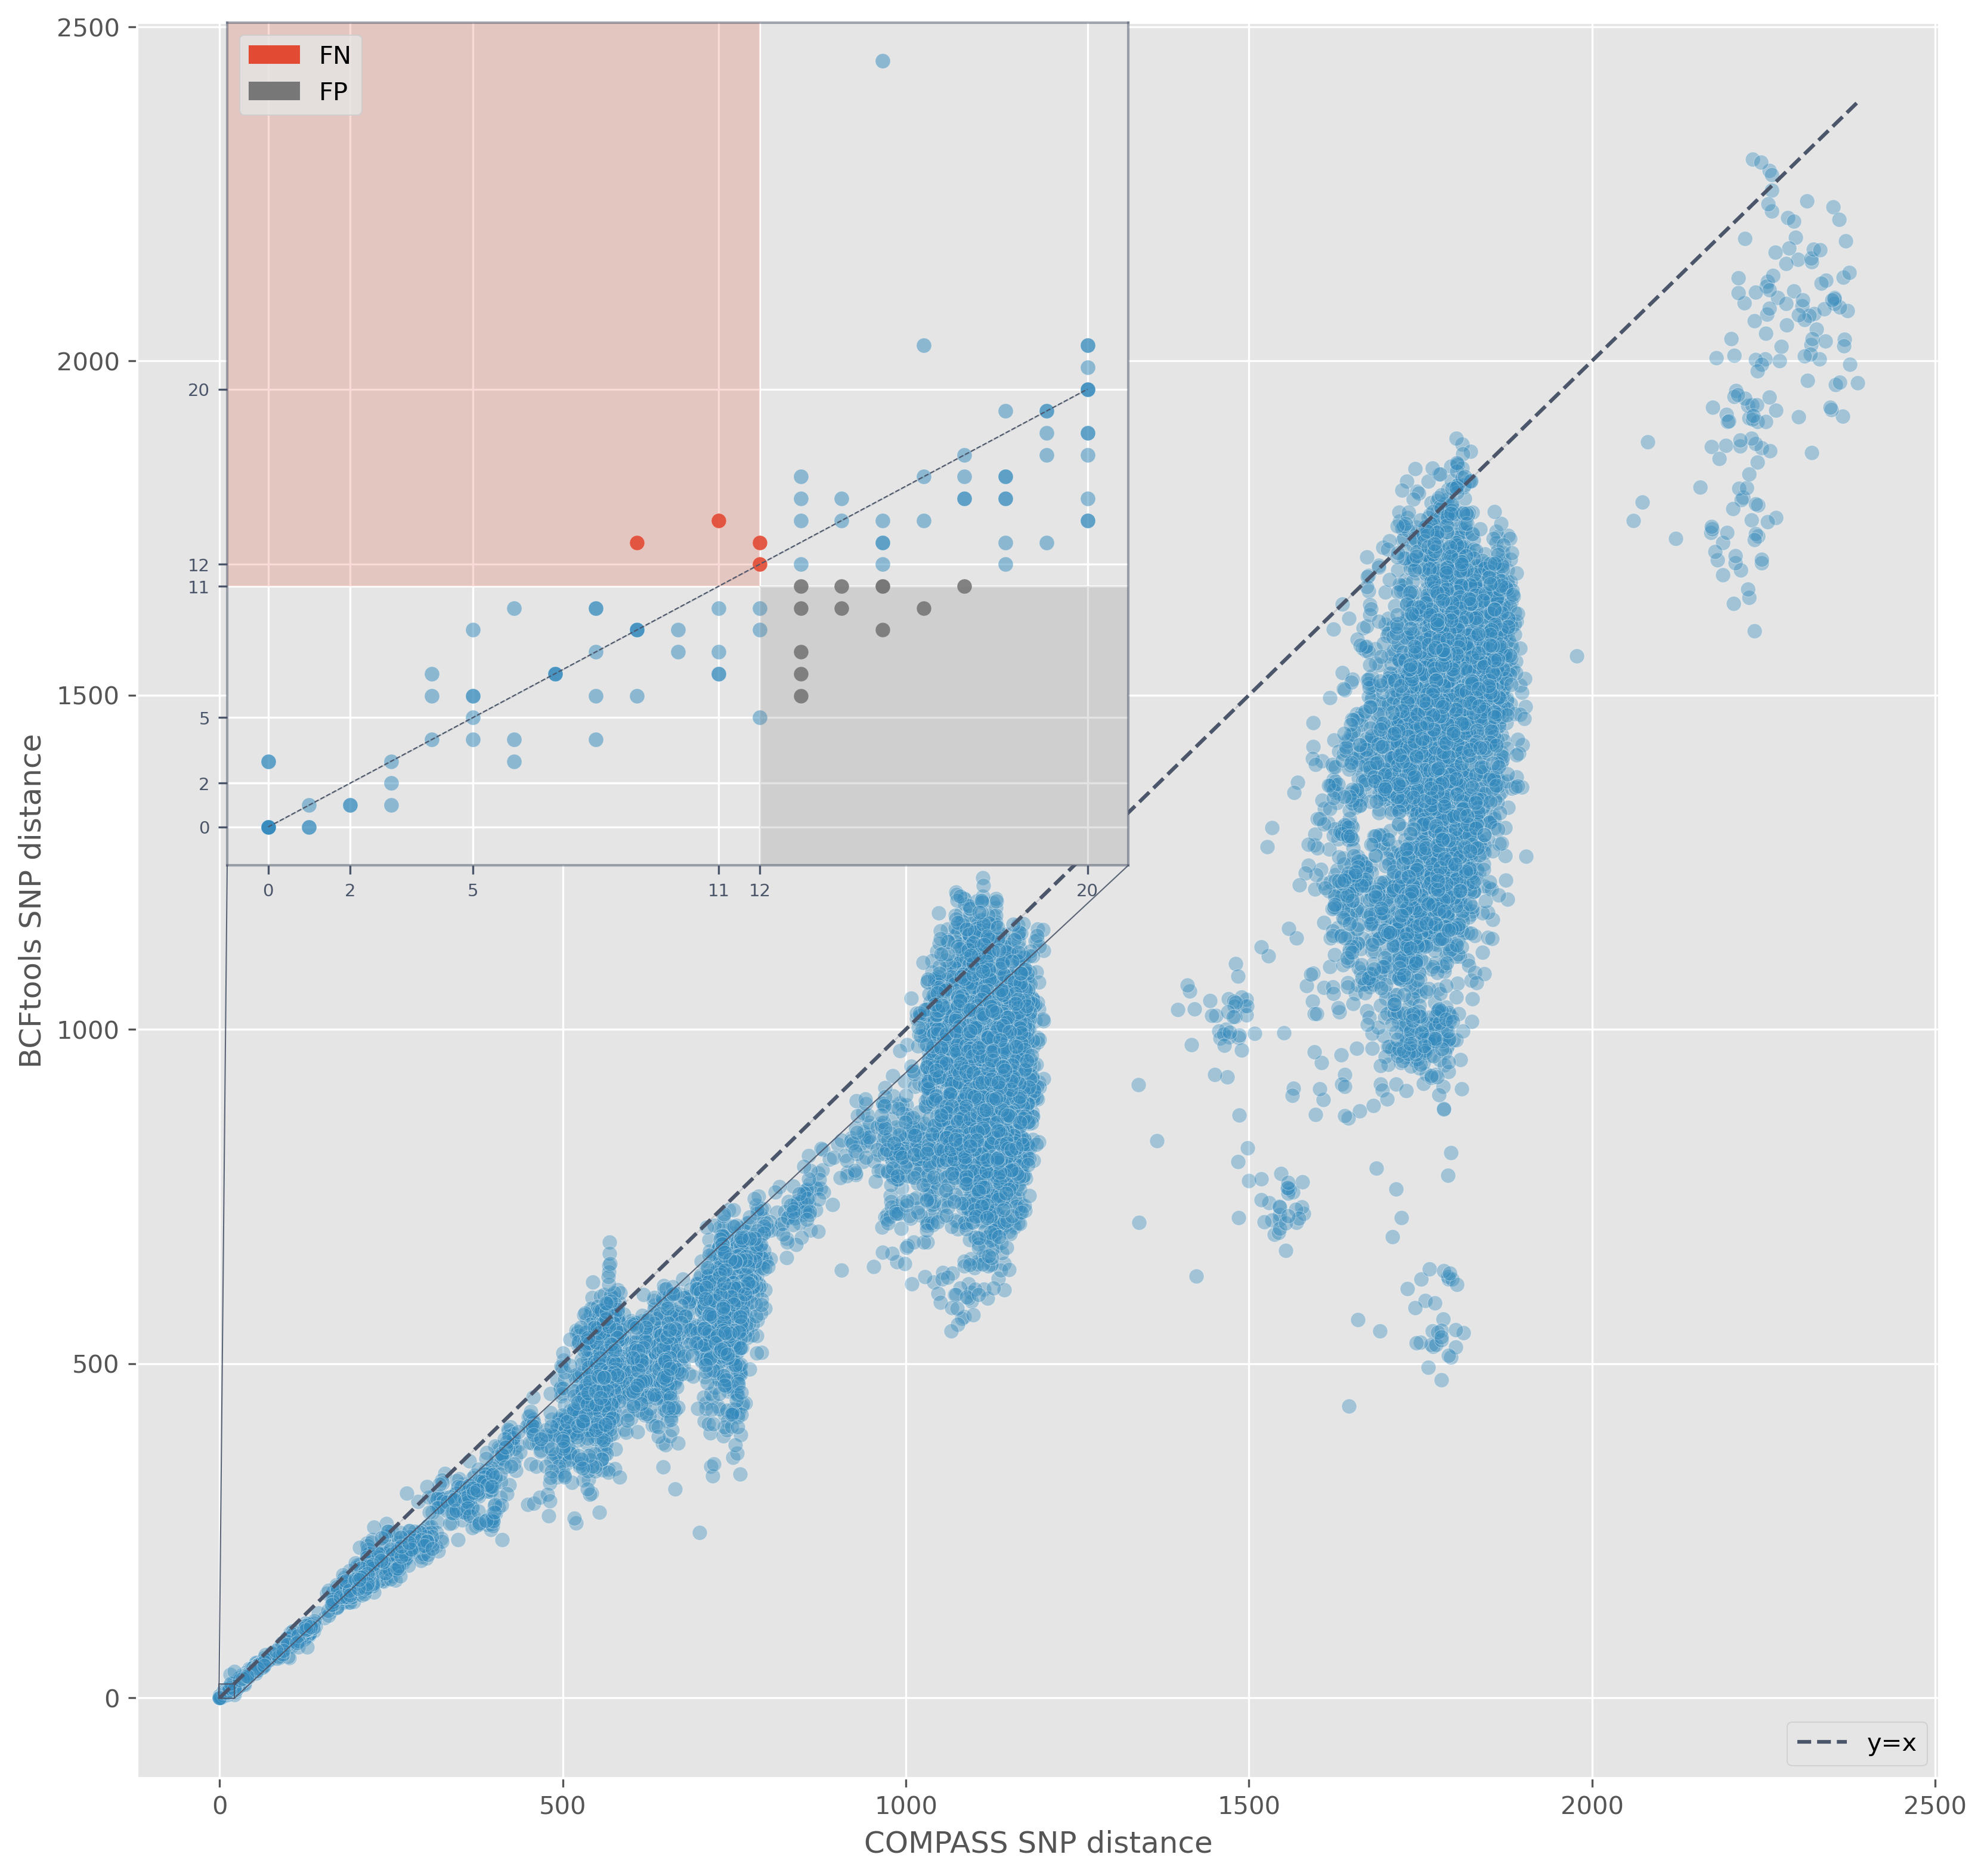

In [27]:
fig, ax = plt.subplots(figsize=(13, 13), dpi=300)

# plot the full set of pairs
kwargs = dict(alpha=0.75, linewidth=0.25)
kwargs["alpha"] /= 2
sns.scatterplot(data=data, x=XCOL, y=YCOL, color=BLUE, ax=ax, **kwargs)

# fit robust linear regression
xs = data[XCOL]
# ys = data[YCOL]
# y_pred = robust_regression(xs, ys)
# slope, intercept, *_ = fit_model(xs, y_pred)
# equation = f"y={slope:.3f}x+{intercept:.3f}"

# plot line of best fit as defined by the model
# sns.lineplot(x=xs, y=y_pred, ax=ax, label=equation, color=BLUE)
# plot identity line
sns.lineplot(x=xs, y=xs, ax=ax, label="y=x", color=BLACK, linestyle="--")
ax.set_xlabel("COMPASS SNP distance")
ax.set_ylabel("BCFtools SNP distance")
ax.legend(loc="lower right")

# set the lower left corner of the zoom inset (x0, y0, width, height)
axins = ax.inset_axes(bounds=[0.05, 0.52, 0.5, 0.48])
# sub region of the original image
threshold = 20
inset_data = data.query(f"{XCOL} <= @threshold")

kwargs["alpha"] *= 2


# plot line of best fit as defined by the model
xs = inset_data[XCOL]
# ys = inset_data[YCOL]
# y_pred = robust_regression(xs, ys)
# slope, intercept, *_ = fit_model(xs, y_pred)
# equation = f"y={slope:.3f}x+{intercept:.3f}"

# plot line of best fit as defined by the model
# sns.lineplot(x=xs, y=y_pred, ax=axins, label=equation, color=BLUE)

# plot identity line
sns.lineplot(x=xs, y=xs, ax=axins, label="y=x", color=BLACK, linestyle="--", linewidth=0.5)

# set the inset axis limits
axins.set_xlim(auto=True)
axins.set_ylim(auto=True)

# styling of the inset zoom lines
rectangle_patch, connector_lines = ax.indicate_inset_zoom(axins, alpha=0.9, edgecolor=BLACK)

# explicitly make the lines for the zoom window connector from the lower-left and -right corners
for i in range(len(connector_lines)):
    if i % 2 == 0:  # lower-left and lower-right
        connector_lines[i].set_visible(True)
    else:
        connector_lines[i].set_visible(False)

axins.tick_params(color=BLACK, labelcolor=BLACK)
# add a border to the inset
for spine in axins.spines.values():
    spine.set_edgecolor(BLACK)
    spine.set_alpha(0.5)

axins.legend(loc="lower right")

# add threshold-based partitions
illumina_t = 12
nanopore_t = 11
# axins.axhline(y=nanopore_t, color="black", linestyle="--", alpha=0.25)
# axins.axvline(x=illumina_t, color="black", linestyle="--", alpha=0.25)

kwargs = dict(alpha=0.9, linewidth=0.1)
# partition data into the quadrants
ont_fns = inset_data.query(f"{YCOL}>@nanopore_t and {XCOL}<=@illumina_t")
ont_fps = inset_data.query(f"{YCOL}<=@nanopore_t and {XCOL}>@illumina_t")
good_data = inset_data[~inset_data.index.isin(ont_fns.index)]
good_data = good_data[~good_data.index.isin(ont_fps.index)]
axins = sns.scatterplot(data=good_data, x=XCOL, y=YCOL, ax=axins, color=BLUE, alpha=0.5, linewidth=0.1)
axins = sns.scatterplot(data=ont_fns, x=XCOL, y=YCOL, ax=axins, color=RED, **kwargs)
axins = sns.scatterplot(data=ont_fps, x=XCOL, y=YCOL, ax=axins, color=ggplot_cm[3], **kwargs)

# https://stackoverflow.com/questions/46961465/different-background-colour-areas-on-matplotlib-plot
ymin, ymax = axins.get_ylim()
xmin, xmax = axins.get_xlim()
axins.axhspan(ymin=nanopore_t, ymax=ymax, xmin=0, xmax=((illumina_t-xmin)/(xmax-xmin)), facecolor=RED, alpha=0.2)
axins.axvspan(xmin=illumina_t, xmax=xmax, ymin=0, ymax=((nanopore_t-ymin)/(ymax-ymin)), facecolor=ggplot_cm[3], alpha=0.2)
# fig.savefig(snakemake.output.plot)
axins.set(ylim=(ymin, ymax), xlim=(xmin, xmax))

inset_ticklabels = [0, 2, 5, 11, 12, threshold]
inset_fs = 7
axins.set_xticks(inset_ticklabels)
axins.set_xticklabels(inset_ticklabels, fontsize=inset_fs)
axins.set_yticks(inset_ticklabels)
axins.set_yticklabels(inset_ticklabels, fontsize=inset_fs)
# remove axis labels on inset
axins.set_xlabel("")
axins.set_ylabel("")

red_patch = mpatches.Patch(color=RED, label="FN")
black_patch = mpatches.Patch(color=ggplot_cm[3], label="FP")
axins.legend(handles=[red_patch, black_patch], loc="upper left")

In [13]:
good_data = inset_data.query(f"({XCOL}<=@illumina_t and {YCOL}<=@nanopore_t) or ({XCOL}>@illumina_t and {YCOL}>@nanopore_t)")
outlier_data = inset_data[~inset_data.index.isin(good_data.index)]

In [78]:
ont_fns

,sample1,sample2,COMPASS_dist,ont_dist
2936,R18043,R26791,12,13
4161,R22601,R26791,11,14
5073,R26791,R27937,12,14


In [14]:
outlier_data

,sample1,sample2,COMPASS_dist,ont_dist
3051,R20260,R21408,13,6
3177,R20574,R21408,13,8
3686,R21408,R27725,15,5
4277,R23146,R26778,13,11
4296,R23146,R32929,15,11
5073,R26791,R27937,12,12
6227,R29816,R30234,14,10
6230,R29816,R31095,13,10
7430,mada_1-11,mada_2-42,15,10
10379,mada_115,mada_142,15,10


In [32]:
def f1(x):
    return 0.857*x+-0.519
def f2(x):
    return 0.780*x+1.419

In [38]:
f2(12)

10.779